In [1]:
%config Completer.use_jedi = False

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
data = pd.read_csv(r"D:\Project\SK AI\kaggle\Kaggle-Competition\Playground\academy\dataset\kaggle dataset\train.csv")
test = pd.read_csv(r"D:\Project\SK AI\kaggle\Kaggle-Competition\Playground\academy\dataset\kaggle dataset\test.csv")
data.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

# One-Hot-Encoding and Scaling

In [5]:
def get_preprocessed_data(data, scaler, train_or_not = True):
    data['Nacionality'] = data['Nacionality'].apply(lambda x:0 if x == 1 else 1)
    data['Daytime/evening attendance'] = data['Daytime/evening attendance'].apply(lambda x:0 if x == 1 else 1)
    data['Tuition fees up to date'] = data['Tuition fees up to date'].apply(lambda x:0 if x == 1 else 1)

    one_hot_columns = [
        'Nacionality', 
        'Daytime/evening attendance', 
        'Educational special needs', 
        'Tuition fees up to date', 
        'Scholarship holder',
        'Displaced',
        'Debtor',
        'Gender',
        'International',
    ]
    
    cat_variables = [
        'Marital status', 
        'Application order',
        'Application mode',
        'Course',
        "Mother's qualification",
        "Father's qualification",
        "Mother's occupation",
        "Father's occupation",
    ]

    numerical_variables = [
        'Previous qualification',
        'Admission grade',
        'Age at enrollment',
        'Previous qualification (grade)',
        'Unemployment rate',
        'Inflation rate',
        'GDP',
        'Curricular units 1st sem (credited)',
        'Curricular units 1st sem (enrolled)',
        'Curricular units 1st sem (evaluations)',
        'Curricular units 1st sem (approved)',
        'Curricular units 1st sem (grade)',
        'Curricular units 1st sem (without evaluations)',
        'Curricular units 2nd sem (credited)',
        'Curricular units 2nd sem (enrolled)',
        'Curricular units 2nd sem (evaluations)',
        'Curricular units 2nd sem (approved)',
        'Curricular units 2nd sem (grade)',
        'Curricular units 2nd sem (without evaluations)',
    ]

    data_one_hot_encoded = pd.get_dummies(data, columns = one_hot_columns)
    
    if train_or_not:
        data_scaled = data_one_hot_encoded.copy()
        data_scaled[numerical_variables] = scaler.fit_transform(data_one_hot_encoded[numerical_variables])
    else:
        data_scaled = data_one_hot_encoded.copy()
        data_scaled[numerical_variables] = scaler.transform(data_one_hot_encoded[numerical_variables])

    return one_hot_columns, cat_variables, numerical_variables, data_scaled, scaler

# Base Models & Cross-Validation Scores

In [6]:
def get_cv_results(model, label, train, target, features, params={}, ensemble=False):
    
    X_train = train[features]
    y_train = target
    
    val_scores = [] 
    print(f'{label} Cross-Validation Results\n')
    
    for fold, (train_idx, val_idx) in enumerate(cv_kfold.split(X_train, y_train)):
        # y_train = pd.Series
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_val = y_train.iloc[val_idx]
        
        if ensemble:
            clf = model
        else:
            # Model initialization and training
            clf = model(**params)
        
        clf.fit(X_fold_train, y_fold_train)
        
        # Predict
        y_pred_trn = clf.predict(X_fold_train)
        y_pred_val = clf.predict(X_val)
        train_acc = accuracy_score(y_fold_train, y_pred_trn)
        val_acc = accuracy_score(y_val, y_pred_val)
        print(f"Fold: {fold}, Train Accuracy: {train_acc:.5f}, Val Accuracy: {val_acc:.5f}")
        
        val_scores.append(val_acc)

    # Calculate the average validation score
    average_val_accuracy = np.mean(val_scores)
    print("\nAverage Validation Accuracy:", average_val_accuracy)

    return clf, average_val_accuracy

In [7]:
data_train = data.drop(['Target', 'id'], axis = 1)
data_target = data['Target']

le = LabelEncoder()
data_target = le.fit_transform(data_target)
data_target = pd.DataFrame(data_target)

In [8]:
scaler = StandardScaler()

_, train_cat_variables, _, train_data_scaled, scaler = get_preprocessed_data(data_train, scaler, train_or_not = True)
_, test_cat_variables, _, test_data_scaled, _ = get_preprocessed_data(test, scaler, train_or_not = False)

In [52]:
test_data_scaled

,id,Marital status,Application mode,Application order,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Scholarship holder_0,Scholarship holder_1,Displaced_0,Displaced_1,Debtor_0,Debtor_1,Gender_0,Gender_1,International_0,International_1
0,76518,1,1,1,9500,-0.308308,0.784087,3,1,2,...,True,False,True,False,True,False,True,False,True,False
1,76519,1,1,1,9238,-0.308308,-0.398241,1,19,4,...,True,False,True,False,True,False,True,False,True,False
2,76520,1,1,1,9238,-0.308308,-1.307724,1,19,4,...,False,True,True,False,True,False,True,False,True,False
3,76521,1,44,1,9147,4.098145,-0.216345,1,19,3,...,False,True,True,False,True,False,True,False,True,False
4,76522,1,39,1,9670,-0.308308,-2.035311,1,37,5,...,True,False,False,True,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,127525,1,1,2,171,-0.308308,-0.398241,38,37,7,...,True,False,False,True,True,False,True,False,True,False
51008,127526,2,39,1,9119,1.778959,0.065595,19,37,9,...,True,False,True,False,False,True,False,True,True,False
51009,127527,1,1,1,171,-0.308308,-0.489190,1,1,4,...,True,False,True,False,False,True,True,False,True,False
51010,127528,1,1,3,9773,-0.308308,-0.034448,19,19,5,...,True,False,False,True,False,True,True,False,True,False


In [9]:
train_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 45 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Previous qualification                          76518 non-null  float64
 5   Previous qualification (grade)                  76518 non-null  float64
 6   Mother's qualification                          76518 non-null  int64  
 7   Father's qualification                          76518 non-null  int64  
 8   Mother's occupation                             76518 non-null  int64  
 9   Father's occupation                    

In [10]:
cv_kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

In [11]:
xgb_model, xgb_mean_accuracy = get_cv_results(
    XGBClassifier, # model
    'XGBoost', # label
    train_data_scaled, # train
    data_target, # target
    train_data_scaled.columns, # features
    {'device': 'cuda'}, # params
)

XGBoost Cross-Validation Results

Fold: 0, Train Accuracy: 0.87887, Val Accuracy: 0.82697
Fold: 1, Train Accuracy: 0.87920, Val Accuracy: 0.82933
Fold: 2, Train Accuracy: 0.88030, Val Accuracy: 0.83625
Fold: 3, Train Accuracy: 0.88093, Val Accuracy: 0.82227
Fold: 4, Train Accuracy: 0.88014, Val Accuracy: 0.83455
Fold: 5, Train Accuracy: 0.87731, Val Accuracy: 0.83351
Fold: 6, Train Accuracy: 0.87914, Val Accuracy: 0.83508
Fold: 7, Train Accuracy: 0.87940, Val Accuracy: 0.82005
Fold: 8, Train Accuracy: 0.87893, Val Accuracy: 0.83675
Fold: 9, Train Accuracy: 0.87925, Val Accuracy: 0.83205

Average Validation Accuracy: 0.8306804600295854


In [13]:
def plot_feature_importances(model, train_set):
    fig = plt.figure(figsize=(10, 6))

    sorted_idx = model.feature_importances_.argsort()
    sns.barplot(y = train_set.columns[sorted_idx], x = model.feature_importances_[sorted_idx])
    plt.xlabel('Model Feature Importance')
    plt.ylabel('Feature')
    plt.yticks(fontsize=8)
    plt.show()

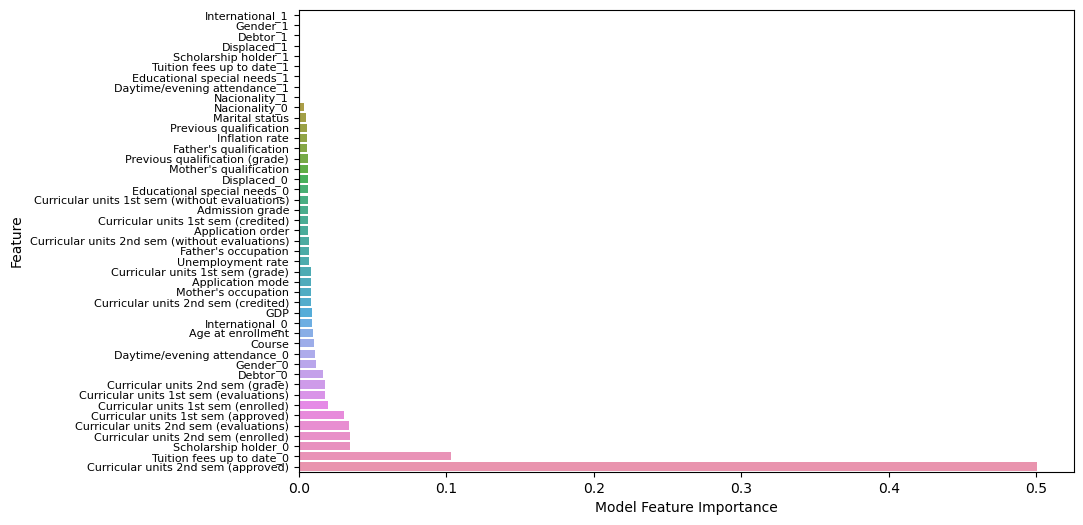

In [16]:
plot_feature_importances(xgb_model, train_data_scaled)

In [17]:
cat_model, cat_mean_accuracy = get_cv_results(
    CatBoostClassifier, 
    'CatBoost', 
    train_data_scaled, 
    data_target,
    train_data_scaled.columns,
    {'verbose': 0, 'allow_writing_files': False, 'task_type': 'GPU'},
)

CatBoost Cross-Validation Results

Fold: 0, Train Accuracy: 0.87898, Val Accuracy: 0.82606
Fold: 1, Train Accuracy: 0.87830, Val Accuracy: 0.82880
Fold: 2, Train Accuracy: 0.87901, Val Accuracy: 0.83481
Fold: 3, Train Accuracy: 0.87949, Val Accuracy: 0.82358
Fold: 4, Train Accuracy: 0.87903, Val Accuracy: 0.83312
Fold: 5, Train Accuracy: 0.87891, Val Accuracy: 0.83233
Fold: 6, Train Accuracy: 0.87939, Val Accuracy: 0.83416
Fold: 7, Train Accuracy: 0.87982, Val Accuracy: 0.82214
Fold: 8, Train Accuracy: 0.87836, Val Accuracy: 0.84107
Fold: 9, Train Accuracy: 0.87888, Val Accuracy: 0.83192

Average Validation Accuracy: 0.8307981309974345


In [33]:
lgb_clf, lgbm_mean_accuracy = get_cv_results(
    LGBMClassifier, 
    'LightGBM', 
    train_data_scaled, 
    data_target,
    train_data_scaled.columns,
    {'verbose': -1, 'device': 'GPU'},
)

LightGBM Cross-Validation Results

Fold: 0, Train Accuracy: 0.85007, Val Accuracy: 0.82723
Fold: 1, Train Accuracy: 0.84865, Val Accuracy: 0.83037
Fold: 2, Train Accuracy: 0.84843, Val Accuracy: 0.83625
Fold: 3, Train Accuracy: 0.84933, Val Accuracy: 0.82527
Fold: 4, Train Accuracy: 0.84962, Val Accuracy: 0.83468
Fold: 5, Train Accuracy: 0.84940, Val Accuracy: 0.83272
Fold: 6, Train Accuracy: 0.84860, Val Accuracy: 0.83534
Fold: 7, Train Accuracy: 0.84982, Val Accuracy: 0.82175
Fold: 8, Train Accuracy: 0.84729, Val Accuracy: 0.83989
Fold: 9, Train Accuracy: 0.84843, Val Accuracy: 0.83257

Average Validation Accuracy: 0.8316083698525378


# LGBM Hyperparameter Random Search

In [47]:
# train data: train_data_scaled
# target data: data_target

def random_lgbm(X,y,n_iter=250):
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 1000, num = 100)]
    
    random_grid = {
        'learning_rate': [0.005, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
        "max_depth"        : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'n_estimators': n_estimators,
        'num_leaves': [6,8,12,16],
        'boosting_type' : ['gbdt'],
        "min_child_weight" : [ 1, 3, 5, 7 ],
        'objective' : ['multiclass'],
        "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        'random_state' : [501], # Updated from 'seed'
        'colsample_bytree' : [0.3, 0.4, 0.65, 0.66],
        'subsample' : [0.7,0.75],
        'reg_alpha' : [1,1.2],
        'reg_lambda' : [1,1.2,1.4],
    }
    
    lgbm_model = LGBMClassifier(n_jobs=-1, device='gpu')
    lgbm_random = RandomizedSearchCV(
        estimator = lgbm_model, 
        param_distributions = random_grid, 
        n_iter = n_iter, 
        cv = 3, 
        verbose=1, 
        random_state=0, 
        n_jobs = -1, 
        scoring = {'NLL':'neg_log_loss', 'Accuracy':'accuracy'}, 
        refit='NLL', 
        return_train_score=False,
    )
    
    # Fit the random search model
    lgbm_random.fit(X, y)
    return lgbm_random.best_estimator_, lgbm_random.cv_results_

In [49]:
X_train, X_val, y_train, y_val = train_test_split(train_data_scaled, data_target, test_size = 0.2, random_state = 0)

In [50]:
n_iter = 150

trained_model, results = random_lgbm(X_train, y_train, n_iter = n_iter)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1391
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 45
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (1.40 MB) transferred to GPU in 0.003243 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.106764
[LightGBM] [Info] Start training from score -1.632975
[LightGBM] [Info] Start training from score -0.746494


In [56]:
results

{'mean_fit_time': array([ 33.73570132,  30.09327126,  20.98696947,  23.36959632,
         17.72218664,  15.59937954,  51.52988466,  42.50733161,
          7.3010567 ,   2.60426776,  12.58043965,  13.06257399,
         35.0713439 ,  48.97819781, 110.10780152,  27.63592768,
         25.1592799 ,  27.17665633,  35.46361868,   8.66640282,
         25.454144  ,   3.20602981,  37.28435802,  55.42332061,
         22.04497155,  21.25766492,   6.47779512,  15.4256165 ,
         82.91777126,   6.61634922,  89.35964147,  55.50243171,
         37.88552507,  53.01207908,  43.59576289,  41.31292629,
          8.1445725 ,  39.83163174,  84.63926395,  35.43987346,
         75.28441064,   1.39342952,  27.66238904,  40.47825607,
         31.74609653,  66.54544036,  86.30561868,  18.15181986,
          5.42927217,  37.41876936,  56.86695647,   2.25293128,
         38.80523141,  57.28160365,  28.45497894,  50.80342023,
         86.95511325,  55.16096354,  10.88813949,  21.99468025,
         28.33500981,  

In [53]:
X_test = test_data_scaled[X_train.columns]
y_pred = trained_model.predict(X_test)
y_pred

[LightGBM] [Warning] Unknown parameter: gamma


array([0, 2, 2, ..., 0, 0, 0])

In [65]:
X_test = test_data_scaled[X_train.columns]
y_pred = xgb_model.predict(X_test)
y_pred

array([0, 2, 2, ..., 0, 0, 0], dtype=int64)

In [66]:
submission = pd.DataFrame(
    {'id': test_data_scaled['id'],
    'Target': le.inverse_transform(y_pred)}
)
submission.to_csv('XGBoostSubmission.csv', index = False)

In [57]:
max([0.83157449, 0.8304963 , 0.83101907, 0.83052899, 0.83206456,
        0.82941813, 0.8291731 , 0.8290914 , 0.7599569 , 0.8137845 ,
        0.80403184, 0.83114977, 0.83227694, 0.82943445, 0.82631427,
        0.83129678, 0.83177053, 0.83165616, 0.82765384, 0.83170519,
        0.83065966, 0.82995724, 0.83199925, 0.83199923, 0.83163984,
        0.83163985, 0.83074134, 0.83150917, 0.83043096, 0.83087204,
        0.82549746, 0.82213224, 0.83178687, 0.83047997, 0.83031662,
        0.8320319 , 0.83097005, 0.82989187, 0.82824192, 0.83155816,
        0.82402722, 0.80056852, 0.82981019, 0.83085569, 0.83136212,
        0.82479501, 0.82227925, 0.83170519, 0.82998988, 0.8319829 ,
        0.82280202, 0.82324309, 0.82762116, 0.82570982, 0.83128044,
        0.82283469, 0.83146013, 0.8309047 , 0.83074135, 0.8315255 ,
        0.83172152, 0.82706574, 0.82788254, 0.83077404, 0.82943448,
        0.82760481, 0.83013691, 0.82783354, 0.83092104, 0.83132944,
        0.83093738, 0.83041464, 0.8314438 , 0.82811123, 0.82213223,
        0.83041463, 0.83191754, 0.83106809, 0.8292711 , 0.81971448,
        0.83052898, 0.82967951, 0.83134577, 0.82858497, 0.83204825,
        0.82389652, 0.83113343, 0.81202019, 0.82822558, 0.82582418,
        0.83046365, 0.83159085, 0.83206457, 0.82616725, 0.83222793,
        0.8256935 , 0.832571  , 0.83092104, 0.83075769, 0.83219525,
        0.83150915, 0.83154182, 0.72514462, 0.83154182, 0.82780084,
        0.81376818, 0.82847063, 0.82771916, 0.82742513, 0.83132946,
        0.82832362, 0.8114321 , 0.83186854, 0.82997355, 0.83142746,
        0.8314438 , 0.83196657, 0.83162349, 0.83039829, 0.82791521,
        0.83110075, 0.83142748, 0.83020225, 0.8277355 , 0.83049632,
        0.82749047, 0.83141115, 0.82806222, 0.83020226, 0.82956515,
        0.82963049, 0.83168888, 0.8140622 , 0.83097006, 0.82907504,
        0.83204824, 0.8311661 , 0.83033295, 0.83031662, 0.82355343,
        0.82585683, 0.82371684, 0.8292711 , 0.83092106, 0.82961415,
        0.83212992, 0.81041925, 0.8240272 , 0.83119877, 0.83154182])

0.832571